<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Static-parameters" data-toc-modified-id="Static-parameters-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Static parameters</a></span></li><li><span><a href="#Gate-parameters" data-toc-modified-id="Gate-parameters-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Gate parameters</a></span></li><li><span><a href="#Optimization-and-fidelity" data-toc-modified-id="Optimization-and-fidelity-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Optimization and fidelity</a></span></li><li><span><a href="#Sweep-paramters" data-toc-modified-id="Sweep-paramters-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Sweep paramters</a></span></li><li><span><a href="#Fidelity-vs-detuning-plot-for-paper" data-toc-modified-id="Fidelity-vs-detuning-plot-for-paper-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Fidelity vs detuning plot for paper</a></span></li></ul></div>

In [18]:
import sys
sys.dont_write_bytecode = True
import numpy as np
from matplotlib import pyplot as plt
import scipy.integrate
import qutip as qt
sys.path.append('/Users/longnguyen/Documents/GitHub/Fluxonium_berkeley/')
from Fluxonium_hamiltonians import qchard_fluxonium as fluxonium
from Fluxonium_hamiltonians import qchard_coupobj as coupobj
from Fluxonium_hamiltonians import qchard_evolgates as gates
from Fluxonium_hamiltonians import qchard_resonator as resonator
from Fluxonium_hamiltonians import qchard_rotope as op
import plotting_settings
from scipy.optimize import minimize
from qutip import*
from datetime import datetime
import matplotlib as mpl
mpl.rcParams['figure.dpi']= 300
from matplotlib import rcParams
rcParams['font.family'] = 'serif'
rcParams['font.serif'] = ['Times New Roman']
figpath = '/Users/longnguyen/Google Drive/LBL Research/Illustration/HCF paper/'

# Static parameters

In [307]:
# Parameters from notebook 2e. Multipath coupling. 
#Energies are in GHz

E_L1 = 0.5
E_C1 = 1.0
E_J1 = 4

E_L2 = 0.55
E_C2 = 1.0
E_J2 = 4

J_L = 0.002
J_C = 0.0115
phi_ext_A = np.pi
phi_ext_B = np.pi

method = 'propagator'

# Hilbert space.
nlev_q = 5

# Indices of the computational space.
comp_space = ['00', '01', '10', '11']
interaction = 'on'

# Instantiate objects
qubitA = fluxonium.Fluxonium(
    E_L=E_L1, E_C=E_C1, E_J=E_J1, nlev=nlev_q, phi_ext = phi_ext_A)
qubitB = fluxonium.Fluxonium(
    E_L=E_L2, E_C=E_C2, E_J=E_J2, nlev=nlev_q, phi_ext = phi_ext_B)
system = coupobj.CoupledObjects(qubitA, qubitB,
                                [qubitA, qubitB, J_L, 'flux'],
                                [qubitA, qubitB, J_C, 'charge'])

In [325]:
print (abs((system.eigvec_nonint('00').dag() * system.eigvec('00')).data[0,0]))

0.9996542015256583


# Gate parameters

In [245]:
#Define operators
IZ = tensor(qeye(nlev_q), op.sigz(nlev_q))
ZI = tensor(op.sigz(nlev_q), qeye(nlev_q))
XI = tensor(op.sigx(nlev_q), qeye(nlev_q))
IX = tensor(qeye(nlev_q), op.sigx(nlev_q))
YI = tensor(op.sigy(nlev_q), qeye(nlev_q))
IY = tensor(qeye(nlev_q), op.sigy(nlev_q))
state_00 = system.eigvec('00')
state_10 = system.eigvec('10')
state_01 = system.eigvec('01')
state_11 = system.eigvec('11')
sup_state0 = (state_00 + state_01)/np.sqrt(2)
sup_state1 = (state_10 + state_11)/np.sqrt(2)

In [247]:
## Here, check the drive amplitude wrt qubit A
# Calculate the drive frequency.
transition_to_drive = ('00', '10', '01')
level1, level2, level3 = transition_to_drive[0], transition_to_drive[1], transition_to_drive[2]
omega_d = abs(system.freq(level1, level3))

# Pulse shape.
shape = 'cosflattop'  # 'gauss', 'cos' for 1-cos, or 'square'
sigma = 0.25  # sigma in units of T_gate for shape=='gauss'
drag = False
drag_coeff = 0.2

T_gate = 100
T_rise = T_gate/2.0
t_points = np.linspace(0, T_gate, 2 * int(T_gate) + 1)

# Calculate the drive amplitude.
drive_amplitude = 14     # MHz
drive_amplitude = drive_amplitude*1e-3*2*np.pi


matr_el = np.abs(system.phi_ij(qubitA, level1, level2))
epsilon = drive_amplitude / abs(matr_el)

# The time-independent operator part of the drive term.
H_drive = epsilon*system.phi(0)
U_t = gates.evolution_operator_microwave_nonorm(system.H(), H_drive, t_points=t_points,T_gate=T_gate, T_rise = T_rise,shape=shape, sigma=sigma, DRAG = drag, DRAG_coefficient = drag_coeff, omega_d=omega_d,interaction=interaction)

(0.0, 1.0)

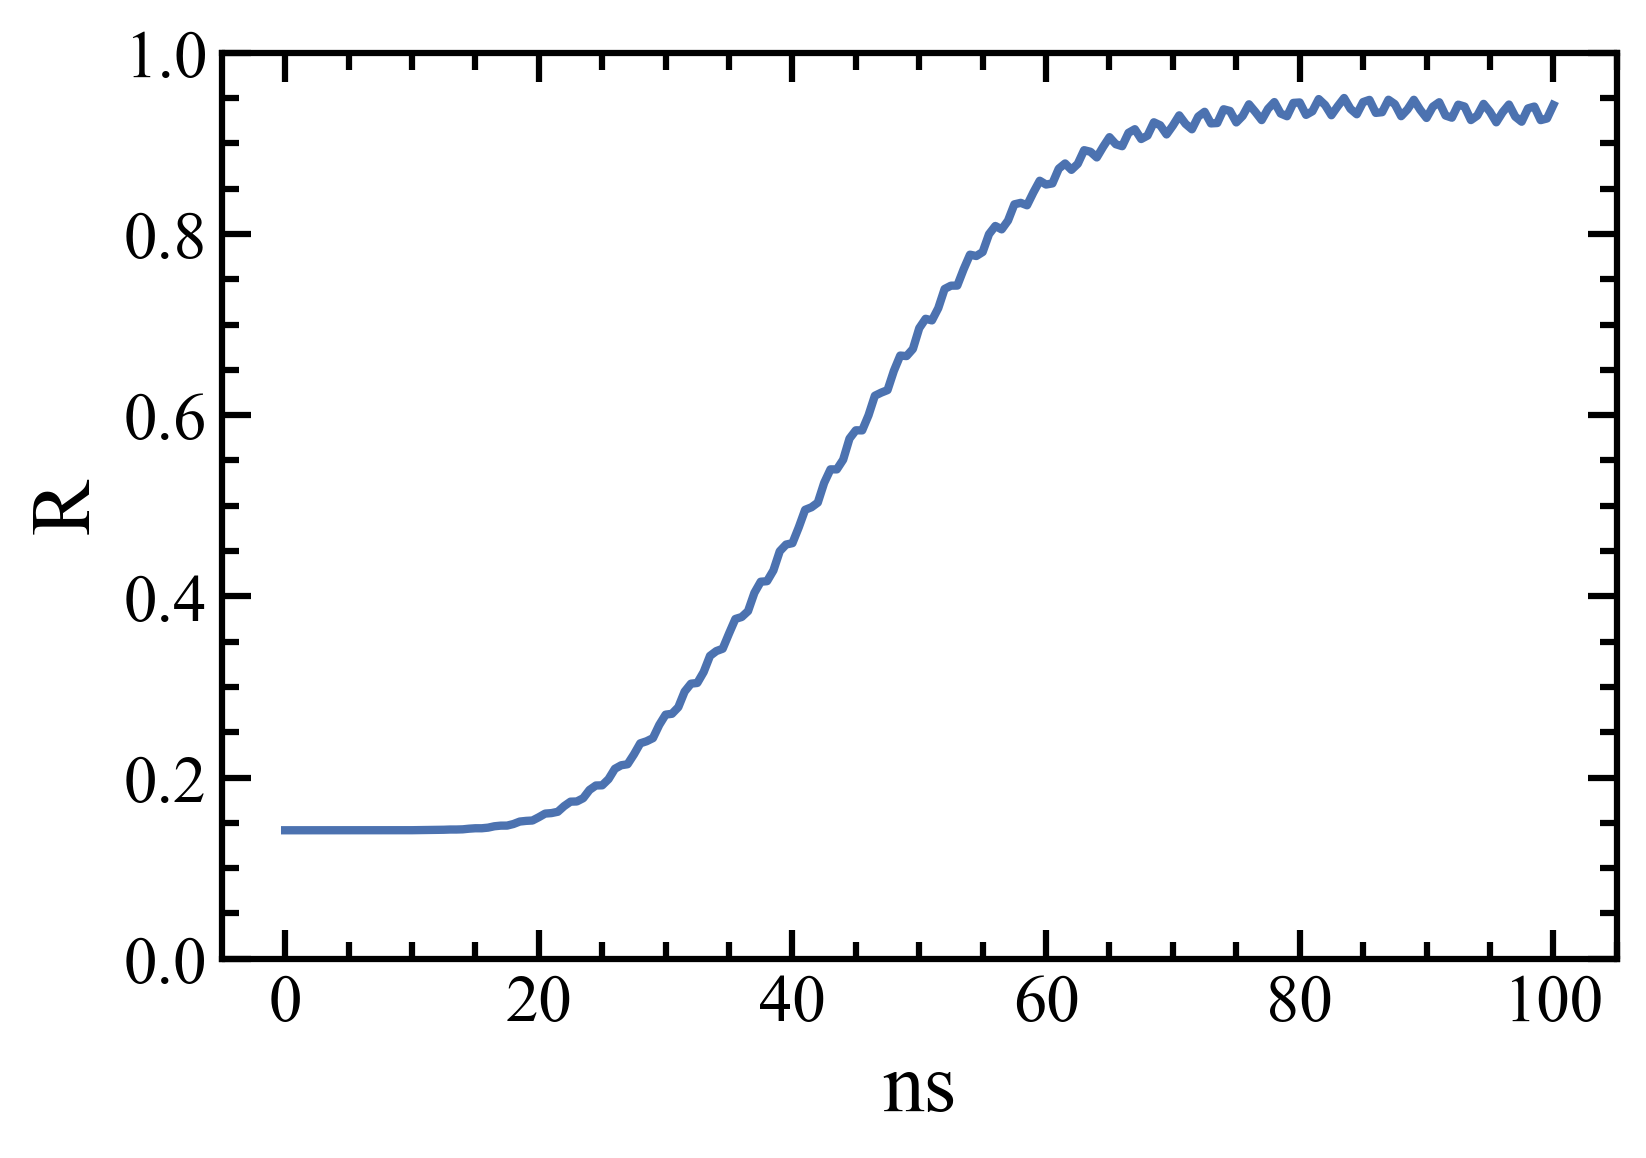

In [248]:
# state_00 = tensor(basis(nlev_q,0),basis(nlev_q,0))
# state_10 = tensor(basis(nlev_q,1),basis(nlev_q,0))
# state_01 = tensor(basis(nlev_q,0),basis(nlev_q,1))
# state_11 = tensor(basis(nlev_q,1),basis(nlev_q,1))

sx0 = expect(IX,U_t*state_00)
sy0 = expect(IY,U_t*state_00)
sz0 = expect(IZ,U_t*state_00)
sx1 = expect(IX,U_t*state_10)
sy1 = expect(IY,U_t*state_10)
sz1 = expect(IZ,U_t*state_10)
R = 0.5*np.sqrt((sx0-sx1)**2 + (sy0-sy1)**2+(sz0-sz1)**2)

plt.plot(t_points, R)
plt.ylabel('R')
plt.xlabel('ns')
plt.ylim([0,1])

# Optimization and fidelity

In [244]:
ZX = tensor(sigmaz(),sigmax())
U_ZX = (ZX*1j*np.pi/4.0).expm()
print (U_ZX*np.sqrt(2))

Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = False
Qobj data =
[[1.+0.j 0.+1.j 0.+0.j 0.+0.j]
 [0.+1.j 1.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 1.+0.j 0.-1.j]
 [0.+0.j 0.+0.j 0.-1.j 1.+0.j]]


In [207]:
omega_d = abs(system.freq(level1, level3))
T_gate = 200
T_rise = T_gate/3.0

def infidelity(x):
    drive_amplitude = x[0]  # MHz
    drive_amplitude = drive_amplitude*1e-3*2*np.pi
    epsilon = drive_amplitude / abs(matr_el)
    H_drive = epsilon*system.phi(0)
    U_t = gates.evolution_operator_microwave_nonorm(system.H(), H_drive, t_points=t_points,T_gate=T_gate, T_rise = T_rise, shape=shape, DRAG = drag, DRAG_coefficient = drag_coeff, omega_d=omega_d,interaction=interaction)
    sx0 = expect(IX,U_t[-1]*state_00)
    sy0 = expect(IY,U_t[-1]*state_00)
    sz0 = expect(IZ,U_t[-1]*state_00)
    sx1 = expect(IX,U_t[-1]*state_10)
    sy1 = expect(IY,U_t[-1]*state_10)
    sz1 = expect(IZ,U_t[-1]*state_10)
    R = 0.5*np.sqrt((sx0-sx1)**2 + (sy0-sy1)**2+(sz0-sz1)**2)
    return (1.0 - R)

x0 = [13]
xopt = minimize(infidelity, x0, method ='Nelder-Mead', tol = None)
infidel = infidelity(xopt.x)
print (infidel, xopt.x)

0.04243560316738981 [16.13106079]


In [334]:
E_L1 = 0.5
E_C1 = 1.0
E_J1 = 4.0

E_L2 = 0.58
E_C2 = 1.0
E_J2 = 4.0

J_L = 0.002
J_C = 0.0115
phi_ext_A = np.pi
phi_ext_B = np.pi

method = 'propagator'

# Hilbert space.
nlev_q = 5

# Indices of the computational space.
comp_space = ['00', '01', '10', '11']
interaction = 'on'

# Instantiate objects
qubitA = fluxonium.Fluxonium(
    E_L=E_L1, E_C=E_C1, E_J=E_J1, nlev=nlev_q, phi_ext = phi_ext_A)
qubitB = fluxonium.Fluxonium(
    E_L=E_L2, E_C=E_C2, E_J=E_J2, nlev=nlev_q, phi_ext = phi_ext_B)
system = coupobj.CoupledObjects(qubitA, qubitB,
                                [qubitA, qubitB, J_L, 'flux'],
                                [qubitA, qubitB, J_C, 'charge'])

transition_to_drive = ('00', '10', '01')
level1, level2, level3 = transition_to_drive[0], transition_to_drive[1], transition_to_drive[2]
omega_d = abs(system.freq(level1, level3))

if (((system.eigvec_nonint('00').dag()*system.eigvec('00')).data[0,0])>0):
    vec00 = system.eigvec('00')
else:
    vec00 = -system.eigvec('00')
if (((system.eigvec_nonint('01').dag()*system.eigvec('01')).data[0,0])>0):
    vec01 = system.eigvec('01')
else:
    vec01 = -system.eigvec('01')
if (((system.eigvec_nonint('10').dag()*system.eigvec('10')).data[0,0])>0):
    vec10 = system.eigvec('10')
else:
    vec10 = -system.eigvec('10')
if (((system.eigvec_nonint('11').dag()*system.eigvec('11')).data[0,0])>0):
    vec11 = system.eigvec('11')
else:
    vec11 = -system.eigvec('11')
    
    
# vec00 = (system.eigvec('00'))
# vec01 = (system.eigvec('01'))
# vec10 = (system.eigvec('10'))
# vec11 = (system.eigvec('11'))

# vec00 = tensor(basis(nlev_q,0),basis(nlev_q,0))
# vec01 = tensor(basis(nlev_q,0),basis(nlev_q,1))
# vec10 = tensor(basis(nlev_q,1),basis(nlev_q,0))
# vec11 = tensor(basis(nlev_q,1),basis(nlev_q,1))

U_ideal = (vec00*vec00.dag() + vec01*vec01.dag() + vec10*vec10.dag() + vec11*vec11.dag()) \
+ 1.0j*(vec00*vec01.dag() + vec01*vec00.dag()) \
- 1.0j*(vec10*vec11.dag() + vec11*vec10.dag())

# U_ideal = (system.eigvec('00')*system.eigvec('00').dag() + system.eigvec('01')*system.eigvec('01').dag() + system.eigvec('10')*system.eigvec('10').dag() + system.eigvec('11')*system.eigvec('11').dag()) \
# + 1.0j*(system.eigvec('00')*system.eigvec('01').dag() + system.eigvec('01')*system.eigvec('00').dag()) \
# - 1.0j*(system.eigvec('10')*system.eigvec('11').dag() + system.eigvec('11')*system.eigvec('10').dag())

# print (U_ideal)
U_ideal = U_ideal / np.sqrt(2)

matr_el = system.phi_ij(qubitA, level1, level2)
omega_d = abs(system.freq(level1, level3))
T_gate = 100
T_rise = T_gate/2.0
t_points = np.linspace(0, T_gate, 2 * int(T_gate) + 1)

def infidelity(x):
    drive_amplitude = x[0]  # MHz
    drive_amplitude = drive_amplitude*1e-3*2*np.pi
    epsilon = drive_amplitude / abs(matr_el)
    H_drive = epsilon*system.phi(0) 
    U_t = gates.evolution_operator_microwave_nonorm(system.H(), H_drive, t_points=t_points,T_gate=T_gate, T_rise = T_rise, shape=shape, DRAG = drag, DRAG_coefficient = drag_coeff, omega_d=omega_d,interaction=interaction)
    phase0 = np.angle(U_t[-1].matrix_element(vec00, vec00))
    phase1 = np.angle(U_t[-1].matrix_element(vec01, vec01))
    phase2 = np.angle(U_t[-1].matrix_element(vec10, vec10))
    phase3 = np.angle(U_t[-1].matrix_element(vec11, vec11))
    
    single_qu_z = 0
    single_qu_z = single_qu_z + np.exp(-1j*phase0)*vec00*vec00.dag()
    single_qu_z = single_qu_z + np.exp(-1j*phase1)*vec01*vec01.dag()
    single_qu_z = single_qu_z + np.exp(-1j*phase2)*vec10*vec10.dag()
    single_qu_z = single_qu_z + np.exp(-1j*phase3)*vec11*vec11.dag()
#     single_qu_z = single_qu_z + np.exp(1.0j*(phase0 - phase1 - phase2))*system.eigvec('11')*system.eigvec('11').dag()
    U = single_qu_z*U_t[-1] 
#     U_CNOT = U_Z2I * U * U_IX2
    P = vec00*vec00.dag() + vec01*vec01.dag() + vec10*vec10.dag() + vec11*vec11.dag()
    U_real = P * U * P
#     U_real = gates.change_operator_proj_subspace(
#         system, U=U, subspace=comp_space, interaction='on')
    op1 = U_real.dag() * U_real
    op2 = U_real * U_ideal.dag()
    fidel = (op1.tr() + (abs(op2.tr())) ** 2) / 20.0
    return abs(1.0 - fidel)

x0 = [15]
xopt = minimize(infidelity, x0, method ='Nelder-Mead', tol = None)
infidel = infidelity(xopt.x)
print (infidel, xopt.x)

4.805844132993453e-05 [-18.58227539]


In [332]:
(1.6-0.55)/0.005
E_L_array = np.linspace(0.55,1.6,211)
# E_L_array

# Sweep paramters

In [164]:
E_L_array = np.linspace(0.55,1.6,106)
E_L_array

array([0.55, 0.56, 0.57, 0.58, 0.59, 0.6 , 0.61, 0.62, 0.63, 0.64, 0.65,
       0.66, 0.67, 0.68, 0.69, 0.7 , 0.71, 0.72, 0.73, 0.74, 0.75, 0.76,
       0.77, 0.78, 0.79, 0.8 , 0.81, 0.82, 0.83, 0.84, 0.85, 0.86, 0.87,
       0.88, 0.89, 0.9 , 0.91, 0.92, 0.93, 0.94, 0.95, 0.96, 0.97, 0.98,
       0.99, 1.  , 1.01, 1.02, 1.03, 1.04, 1.05, 1.06, 1.07, 1.08, 1.09,
       1.1 , 1.11, 1.12, 1.13, 1.14, 1.15, 1.16, 1.17, 1.18, 1.19, 1.2 ,
       1.21, 1.22, 1.23, 1.24, 1.25, 1.26, 1.27, 1.28, 1.29, 1.3 , 1.31,
       1.32, 1.33, 1.34, 1.35, 1.36, 1.37, 1.38, 1.39, 1.4 , 1.41, 1.42,
       1.43, 1.44, 1.45, 1.46, 1.47, 1.48, 1.49, 1.5 , 1.51, 1.52, 1.53,
       1.54, 1.55, 1.56, 1.57, 1.58, 1.59, 1.6 ])

In [336]:
E_L_array = np.linspace(0.55,1.6,211)
T_gate = 200
T_rise = T_gate/3.0
t_points = np.linspace(0,T_gate, 2*int(T_gate)+1)

infidelity_array = np.zeros_like(E_L_array)
amplitude_array = np.zeros_like(E_L_array)

E_L1 = 0.5
E_C1 = 1.0
E_J1 = 4

E_C2 = 1.0
E_J2 = 4

J_L = 0.002
J_C = 0.0115
# J_C_array = np.load(figpath+'/optimal_JC.npy')
phi_ext_A = np.pi
phi_ext_B = np.pi

# Pulse shape.
shape = 'cosflattop'  # 'gauss', 'cos' for 1-cos, or 'square'
sigma = 0.25  # sigma in units of T_gate for shape=='gauss'
drag = False
drag_coeff = 0.2

# Hilbert space.
nlev_q = 5

# Indices of the computational space.
interaction = 'on'
comp_space = ['00', '01', '10', '11']

# Instantiate objects
qubitA = fluxonium.Fluxonium(
    E_L=E_L1, E_C=E_C1, E_J=E_J1, nlev=nlev_q, phi_ext = phi_ext_A)

for idx, E_L2 in enumerate(E_L_array):
    #Define qubit B
    qubitB = fluxonium.Fluxonium(
    E_L=E_L2, E_C=E_C2, E_J=E_J2, nlev=nlev_q, phi_ext = phi_ext_B)
    system = coupobj.CoupledObjects(qubitA, qubitB,
                                    [qubitA, qubitB, J_L, 'flux'],
                                    [qubitA, qubitB, J_C, 'charge'])  
    #Define drive frequency
    transition_to_drive = ('00', '10', '01')
    level1, level2, level3 = transition_to_drive[0], transition_to_drive[1], transition_to_drive[2]
    omega_d = abs(system.freq(level1, level3))
    
    matr_el = np.abs(system.phi_ij(qubitA, level1, level2))
    if (((system.eigvec_nonint('00').dag()*system.eigvec('00')).data[0,0])>0):
        vec00 = system.eigvec('00')
    else:
        vec00 = -system.eigvec('00')
    if (((system.eigvec_nonint('01').dag()*system.eigvec('01')).data[0,0])>0):
        vec01 = system.eigvec('01')
    else:
        vec01 = -system.eigvec('01')
    if (((system.eigvec_nonint('10').dag()*system.eigvec('10')).data[0,0])>0):
        vec10 = system.eigvec('10')
    else:
        vec10 = -system.eigvec('10')
    if (((system.eigvec_nonint('11').dag()*system.eigvec('11')).data[0,0])>0):
        vec11 = system.eigvec('11')
    else:
        vec11 = -system.eigvec('11')

    U_ideal = (vec00*vec00.dag() + vec01*vec01.dag() + vec10*vec10.dag() + vec11*vec11.dag()) \
    + 1.0j*(vec00*vec01.dag() + vec01*vec00.dag()) \
    - 1.0j*(vec10*vec11.dag() + vec11*vec10.dag())
    U_tar = U_ideal / np.sqrt(2)
    U_ideal = gates.change_operator_proj_subspace(
            system, U=U_tar, subspace=comp_space, interaction='on')
    
    def infidelity(x):
        drive_amplitude = x[0]  # MHz
        drive_amplitude = drive_amplitude*1e-3*2*np.pi
        epsilon = drive_amplitude / abs(matr_el)
        H_drive = epsilon*system.phi(0) 
        U_t = gates.evolution_operator_microwave_nonorm(system.H(), H_drive, t_points=t_points,T_gate=T_gate, T_rise = T_rise, shape=shape, DRAG = drag, DRAG_coefficient = drag_coeff, omega_d=omega_d,interaction=interaction)
        phase0 = np.angle(U_t[-1].matrix_element(system.eigvec('00').dag(), system.eigvec('00')))
        phase1 = np.angle(U_t[-1].matrix_element(system.eigvec('01').dag(), system.eigvec('01')))
        phase2 = np.angle(U_t[-1].matrix_element(system.eigvec('10').dag(), system.eigvec('10')))
        phase3 = np.angle(U_t[-1].matrix_element(system.eigvec('11').dag(), system.eigvec('11')))

        single_qu_z = 0
        single_qu_z = single_qu_z + np.exp(-1j*phase0)*system.eigvec('00')*system.eigvec('00').dag()
        single_qu_z = single_qu_z + np.exp(-1j*phase1)*system.eigvec('01')*system.eigvec('01').dag()
        single_qu_z = single_qu_z + np.exp(-1j*phase2)*system.eigvec('10')*system.eigvec('10').dag()
        single_qu_z = single_qu_z + np.exp(-1j*phase3)*system.eigvec('11')*system.eigvec('11').dag()
#         single_qu_z = single_qu_z + np.exp(1.0j*(phase0 - phase1 - phase2))*system.eigvec('11')*system.eigvec('11').dag()
        U = single_qu_z*U_t[-1] 

        U_real = gates.change_operator_proj_subspace(
            system, U=U, subspace=comp_space, interaction='on')
        op1 = U_real.dag() * U_real
        op2 = U_real * U_ideal.dag()
        fidel = (op1.tr() + (abs(op2.tr())) ** 2) / 20.0
#         fidel = gates.fidelity_twoq_general(U_ideal, U_real)
        return abs(1.0 - fidel)
    
    if idx == 0:
        amplitude_guess = -5
    else:
        amplitude_guess = amplitude_array[idx-1]
    x0 = [amplitude_guess]
    xopt = minimize(infidelity, x0, method ='Nelder-Mead', tol = None)
    amplitude_array[idx] = xopt.x[0]
    infidelity_array[idx] = infidelity(xopt.x)
    print (idx)
    print (xopt.x)
    print(infidelity(xopt.x))
    now = datetime.now()
    # dd/mm/YY H:M:S
    dt_string = now.strftime("%d/%m/%Y %H:%M:%S")
    print("date and time =", dt_string)
np.save(figpath+'/CR_fidelity_vs_detuning_1GHz_200ns_full.npy', infidelity_array)

0
[-4.99621582]
4.264886073856999e-06
date and time = 29/12/2021 23:39:37
1
[-5.40038968]
6.977817609721271e-06
date and time = 29/12/2021 23:45:49
2
[5.81979006]
1.1469642861805518e-05
date and time = 29/12/2021 23:56:08
3
[-6.25392991]
1.044910575775937e-05
date and time = 30/12/2021 00:07:48
4
[-6.702286]
9.531781447913446e-06
date and time = 30/12/2021 00:13:38
5
[-7.16429538]
1.0301462981310294e-05
date and time = 30/12/2021 00:18:51
6
[-7.63969955]
8.600346951270765e-06
date and time = 30/12/2021 00:23:55
7
[-8.12827848]
8.234660123562776e-06
date and time = 30/12/2021 00:28:52
8
[-8.62974723]
1.0896320465692e-05
date and time = 30/12/2021 00:33:39
9
[-9.14398198]
1.1764740449948796e-05
date and time = 30/12/2021 00:38:35
10
[-9.67088832]
1.235185201620137e-05
date and time = 30/12/2021 00:43:24
11
[-10.2104488]
1.3456055167226921e-05
date and time = 30/12/2021 00:48:14
12
[-10.76260076]
1.3453253904449625e-05
date and time = 30/12/2021 00:53:00
13
[-11.32733513]
1.48496040914825

108
[-146.17988626]
0.0015968078765533633
date and time = 30/12/2021 09:57:27
109
[-148.80025485]
0.0016481169855454558
date and time = 30/12/2021 10:03:36
110
[-319.09674953]
0.4930495500335035
date and time = 30/12/2021 10:12:02
111
[-154.14186472]
0.0017548163143915607
date and time = 30/12/2021 10:20:08
112
[-156.86362018]
0.0018102759462836904
date and time = 30/12/2021 10:26:18
113
[-159.61973189]
0.0018671769110701897
date and time = 30/12/2021 10:32:29
114
[-162.41056853]
0.001925551021981775
date and time = 30/12/2021 10:38:41
115
[-165.23632309]
0.001985434076593351
date and time = 30/12/2021 10:44:54
116
[-168.0973753]
0.002046856591461532
date and time = 30/12/2021 10:51:08
117
[-170.99411558]
0.0021098456459123227
date and time = 30/12/2021 10:57:22
118
[-173.92674972]
0.0021744409744570703
date and time = 30/12/2021 11:03:37
119
[-176.89554791]
0.002240677445270789
date and time = 30/12/2021 11:09:52
120
[-384.05803312]
0.5072669223877089
date and time = 30/12/2021 11:18:

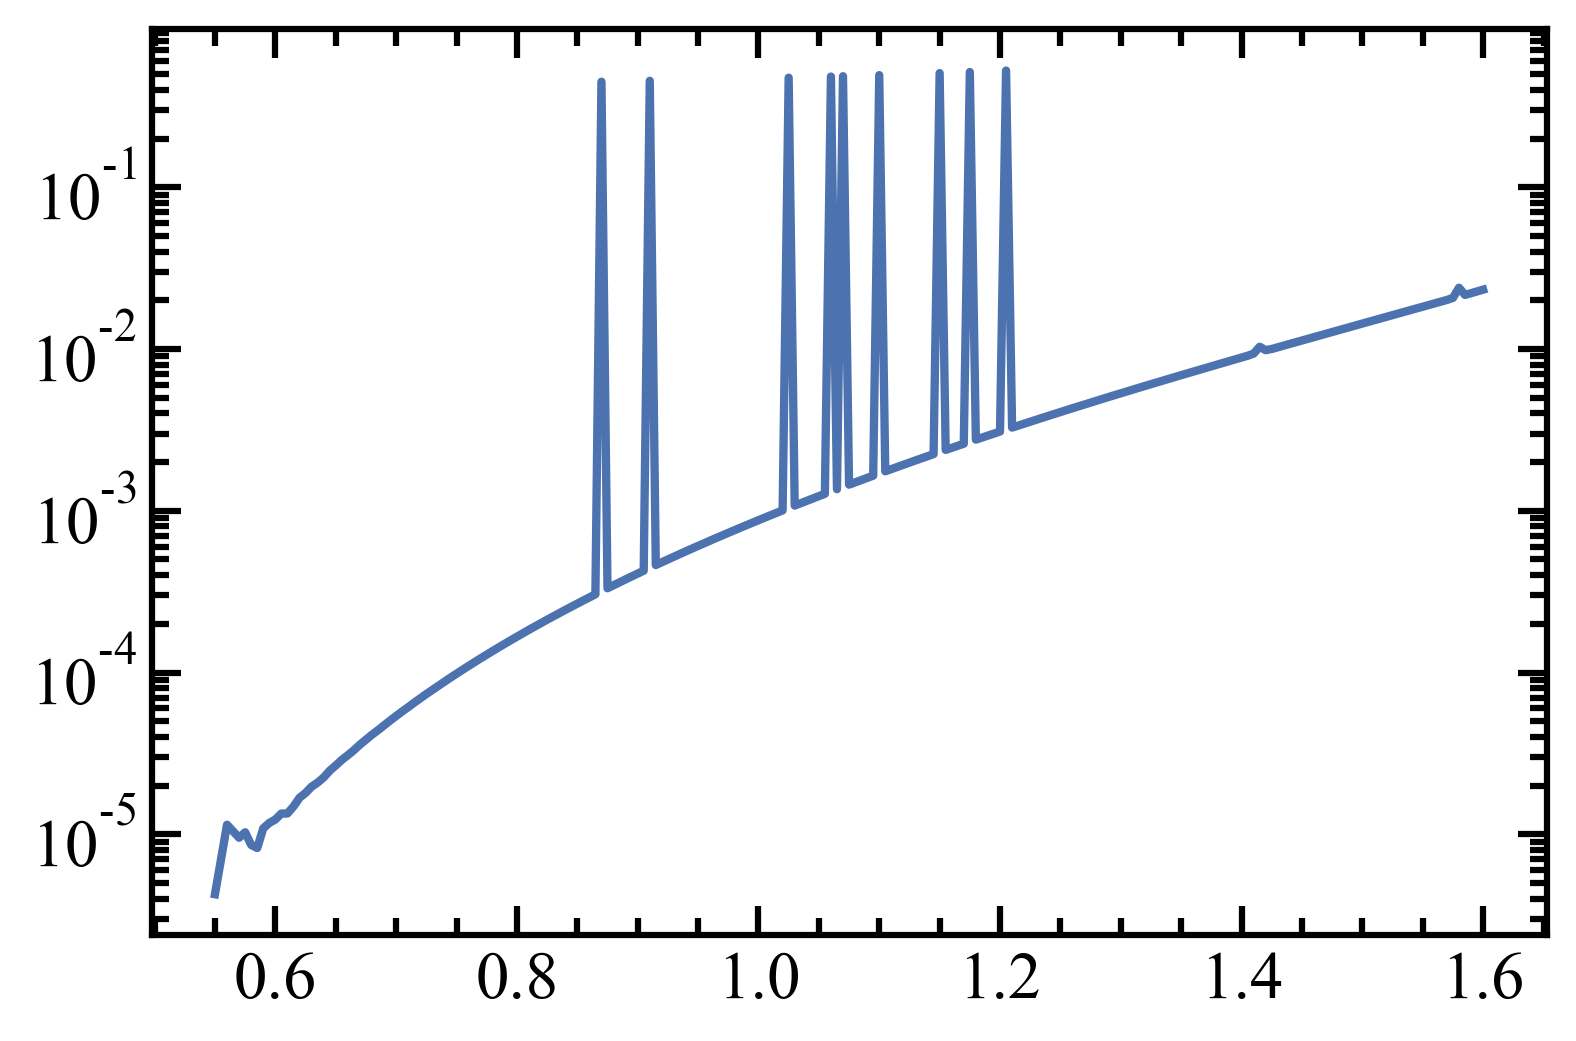

In [337]:
plt.plot(E_L_array,infidelity_array)
plt.yscale('log')

# Fidelity vs detuning plot for paper

In [353]:
#First, compute detuning from EL
E_L = 0.5
E_C = 1.0
E_J = 4
phi_ext = np.pi
nlev_q=5

#Qubit A
qubit = fluxonium.Fluxonium(
    E_L=E_L, E_C=E_C, E_J=E_J, nlev=nlev_q, phi_ext = phi_ext)
w1 = qubit.freq(0,1)

#Qubit B
E_L_array = np.linspace(0.55,1.6,211)
w2_array = np.zeros_like(E_L_array)
for idx, E_L in enumerate(E_L_array):
    qubit = fluxonium.Fluxonium(
    E_L=E_L, E_C=E_C, E_J=E_J, nlev=nlev_q, phi_ext = phi_ext_A)
    w2_array[idx] = qubit.freq(0,1)
detuning = w2_array-w1

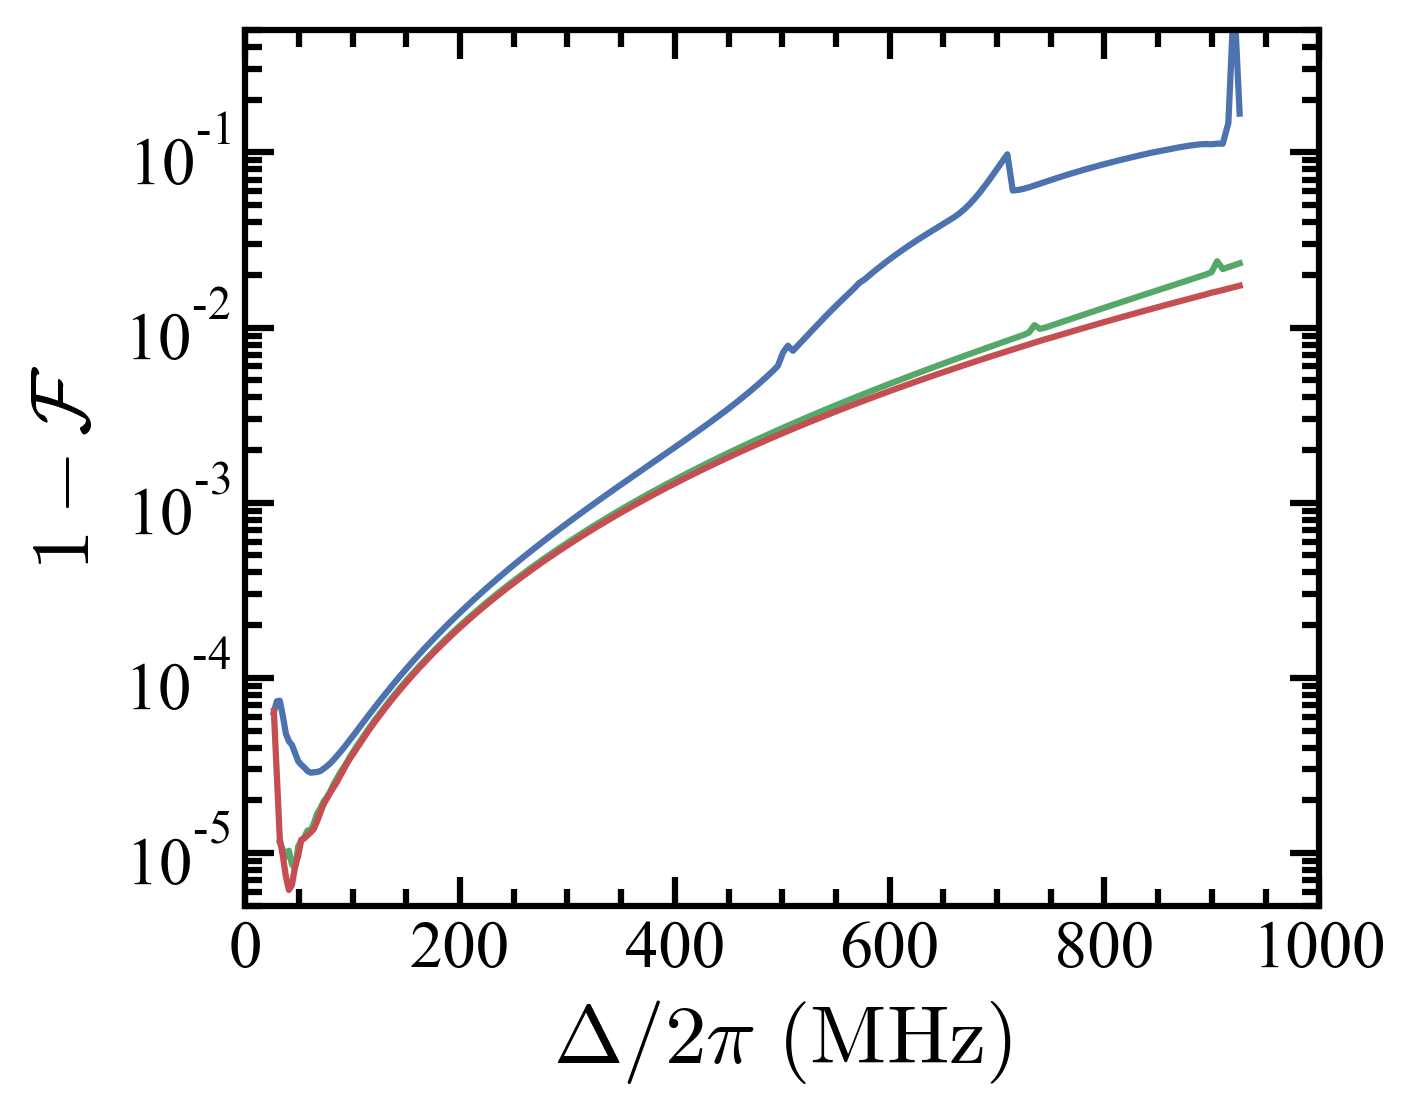

In [361]:
plt.figure(figsize = [5,4])

#100ns gate time
infidelity = np.load(figpath+'/CR_fidelity_vs_detuning_1GHz_100ns_full.npy')
plt.plot(detuning*1e3,infidelity, linewidth = 1.5, label = r'$\tau_g=100~\mathrm{ns}$')
plt.yscale('log')

#200ns gate time
infidelity = np.load(figpath+'/CR_fidelity_vs_detuning_1GHz_200ns_full.npy')
infidelity_refined = []
detuning_refined = []
for idx,error in enumerate(infidelity):
    if error < 1e-1:
        infidelity_refined = np.append(infidelity_refined,infidelity[idx])
        detuning_refined = np.append(detuning_refined,detuning[idx])
plt.plot(detuning_refined[2:]*1e3,infidelity_refined[2:], linewidth = 1.5, label = r'$\tau_g=200~\mathrm{ns}$')
plt.yscale('log')

#300ns gate time
infidelity = np.load(figpath+'/CR_fidelity_vs_detuning_1GHz_300ns_full1.npy')
infidelity_refined = []
detuning_refined = []
for idx,error in enumerate(infidelity):
    if error < 1e-1:
        if error < 2*infidelity[idx-1]:
            infidelity_refined = np.append(infidelity_refined,infidelity[idx])
            detuning_refined = np.append(detuning_refined,detuning[idx])
plt.plot(detuning_refined*1e3,infidelity_refined, linewidth = 1.5, label = r'$\tau_g=300~\mathrm{ns}$')
plt.yscale('log')

#Plotting format
plt.xlabel(r"$\Delta/2\pi~\mathrm{(MHz)}$")
plt.ylabel(r'$1-\mathcal{F}$')
plt.xlim([0,1000])
plt.ylim([5e-6,5e-1])
# plt.legend()
plt.tight_layout()
figname = 'CR_extended.pdf'
plt.savefig(figpath+figname)